In [1]:
import pandas as pd

df = pd.read_csv('positive.csv', na_values=['NULL'])

df['AcquisitionDateTime_DT'] = pd.to_datetime(df['AcquisitionDateTime_DT'])

print(df.head())

print(df.info())
print(df.isnull().sum())

  PatientID                              12SL_Codes Source  \
0   HR00008       22,542,1665,533,1666,780,831,1699  PTBXL   
1   HR00077                         22,964,821,1699  PTBXL   
2   HR00085  22,542,1665,531,1666,1682,740,831,1699  PTBXL   
3   HR00103                     23,470,780,831,1699  PTBXL   
4   HR00128                    22,1682,780,831,1699  PTBXL   

                                          Phys_Codes  MI_12SL  MI_Phys  \
0          164865005, 164951009, 39732003, 426783006        1        1   
1                     426783006, 54329005, 713426002        1        1   
2                                          426783006        1        0   
3  164865005, 164951009, 39732003, 427084000, 445...        1        1   
4                                          164934002        1        0   

   TestID  PatientAge  Gender AcquisitionDateTime_DT  ...  STDOWN_V6  \
0       8         NaN     NaN    2020-04-23 07:59:54  ...          0   
1      77         NaN     NaN    2020-

In [6]:
missing_columns = null_counts[null_counts > 0]
print(missing_columns)

PatientAge     9422
Gender         9422
AtrialRate     1860
P_RInterval    2268
POnset         2341
POffset        2341
PAxis          2313
dtype: int64


In [2]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score


In [3]:
y = df['MI_Phys']

X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=['PatientID', '12SL_Codes', 'Phys_Codes','TestID', 'Source', 'MI_12SL', 'Gender', 'PatientAge', 'AcquisitionDateTime_DT', 'MI_Phys']), y, test_size=0.2, random_state=42)


lgb_params = {
    'objective': 'binary',
    'boosting_type': 'gbdt',
    'n_estimators': 100,
    'learning_rate': 0.03,
    'random_state': 42,
    'verbose': -1,
}

model = (lgb.LGBMClassifier(**lgb_params))

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

score = f1_score(y_test, y_pred, average='micro')
print(score)

# import joblib
# joblib.dump(model, 'model.pkl')




0.8021220159151193


In [10]:
#count number of positive and negative smales based on MI_Phys
print(df['MI_Phys'].value_counts())

MI_Phys
0    5419
1    4003
Name: count, dtype: int64


In [ ]:
estimators = [0.15, 0.11, 0.1, 0.09, 0.08, 0.07]
leaves = [15, 31, 63, 127]
scores = {}
for estims in estimators:
    for num_leaves in leaves:
        lgb_params = {
            'objective': 'binary',
            'boosting_type': 'gbdt',
            'n_estimators': 50,
            'learning_rate': estims,
            'random_state': 42,
            'verbose': -1,
            'num_leaves': num_leaves,
            'scale_pos_weight': 5419/4003,
            }
        model = (lgb.LGBMClassifier(**lgb_params))
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        score = f1_score(y_test, y_pred, average='micro')
        scores[(estims, num_leaves)] = score
        print(f"Learning rate: {estims}, Number of Leaves: {num_leaves} F1 score: {score:.4f}")

Learning rate: 0.15, Number of Leaves: 15 F1 score: 0.8090
Learning rate: 0.15, Number of Leaves: 31 F1 score: 0.8053
Learning rate: 0.15, Number of Leaves: 63 F1 score: 0.8133
Learning rate: 0.15, Number of Leaves: 127 F1 score: 0.8202
Learning rate: 0.11, Number of Leaves: 15 F1 score: 0.8069
Learning rate: 0.11, Number of Leaves: 31 F1 score: 0.8027
Learning rate: 0.11, Number of Leaves: 63 F1 score: 0.8074
Learning rate: 0.11, Number of Leaves: 127 F1 score: 0.8133
Learning rate: 0.1, Number of Leaves: 15 F1 score: 0.7995
Learning rate: 0.1, Number of Leaves: 31 F1 score: 0.8127
Learning rate: 0.1, Number of Leaves: 63 F1 score: 0.8101
Learning rate: 0.1, Number of Leaves: 127 F1 score: 0.8085
Learning rate: 0.09, Number of Leaves: 15 F1 score: 0.8021
Learning rate: 0.09, Number of Leaves: 31 F1 score: 0.8058
Learning rate: 0.09, Number of Leaves: 63 F1 score: 0.8080
Learning rate: 0.09, Number of Leaves: 127 F1 score: 0.8149
Learning rate: 0.08, Number of Leaves: 15 F1 score: 0.79

In [6]:
lgb_params = {
    'objective': 'binary',
    'boosting_type': 'gbdt',
    'n_estimators': 200,
    'learning_rate': 0.15,
    'random_state': 42,
    'verbose': -1,
    'num_leaves': 127,
    'scale_pos_weight': 5419/4003,
    }
model = (lgb.LGBMClassifier(**lgb_params))
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
score = f1_score(y_test, y_pred, average='micro')
print("Final F1 score: ", score)

Final F1 score:  0.8286472148541114


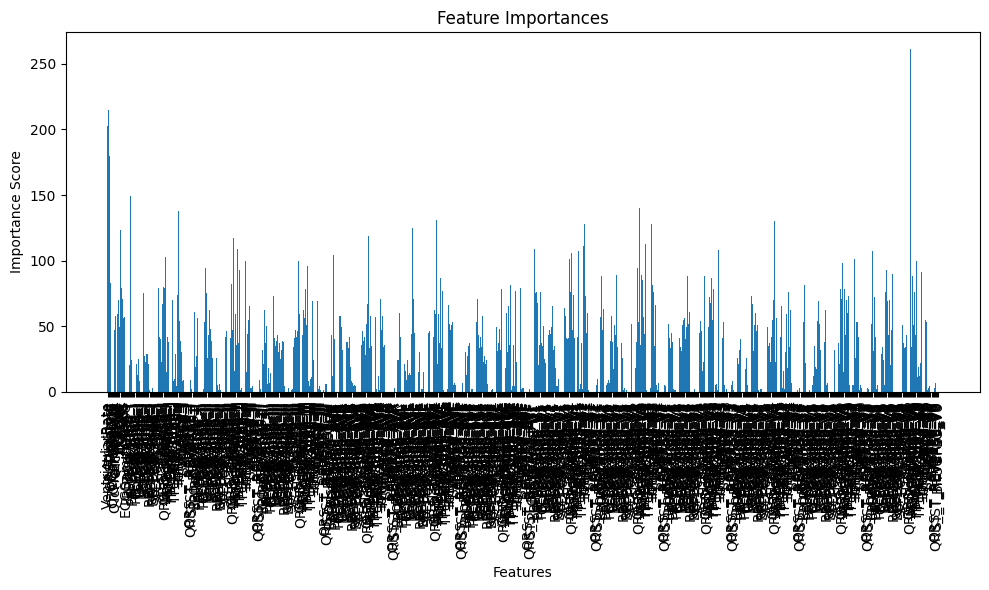

In [7]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'model' is your trained LightGBM model
importances = model.feature_importances_
feature_names = X_train.columns if hasattr(X_train, 'columns') else np.arange(len(importances))

# Create a bar plot of the feature importances
plt.figure(figsize=(10, 6))
plt.bar(range(len(importances)), importances)
plt.xticks(range(len(importances)), feature_names, rotation='vertical')
plt.title("Feature Importances")
plt.xlabel("Features")
plt.ylabel("Importance Score")
plt.tight_layout()
plt.show()


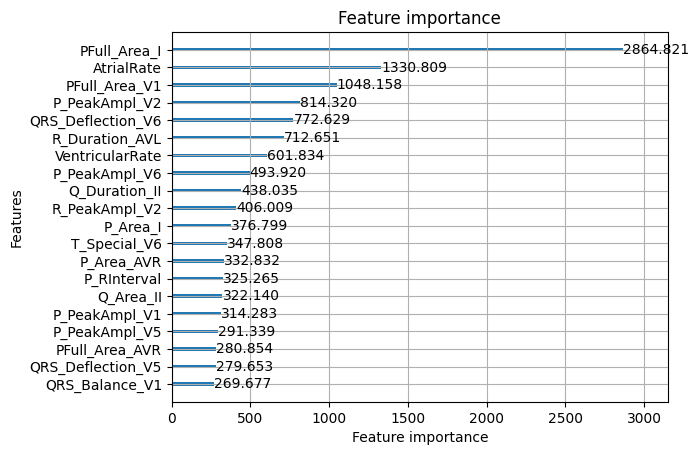

In [8]:
# 'gbm' is the model returned by lgb.train
booster = model.booster_
importances = booster.feature_importance(importance_type='split')  # or use 'gain'
feature_names = booster.feature_name()

lgb.plot_importance(booster, importance_type='gain', max_num_features=20)
plt.show()


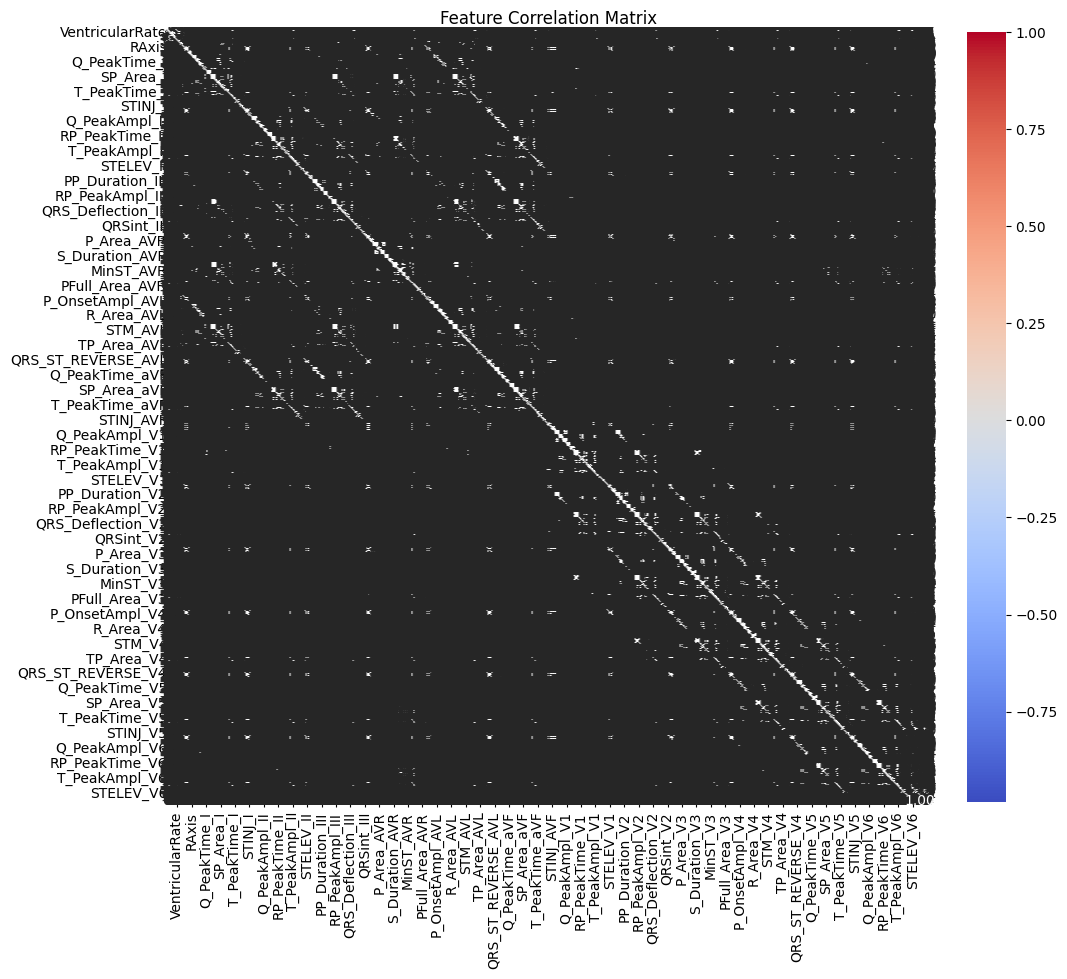

In [10]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assume df is your DataFrame of features
corr_matrix = df.drop(columns=['PatientID', '12SL_Codes', 'Phys_Codes','TestID', 'Source', 'MI_12SL', 'Gender', 'PatientAge', 'AcquisitionDateTime_DT', 'MI_Phys']).corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Feature Correlation Matrix")
plt.show()


In [11]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Standardize your features before PCA (recommended)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df.drop(columns=['PatientID', '12SL_Codes', 'Phys_Codes','TestID', 'Source', 'MI_12SL', 'Gender', 'PatientAge', 'AcquisitionDateTime_DT', 'MI_Phys']))

pca = PCA(n_components=0.95, random_state=42)  # keep 95% of variance
principal_components = pca.fit_transform(X_scaled)

print("Number of components selected:", pca.n_components_)
print("Total variance explained:", pca.explained_variance_ratio_.sum())

ValueError: Input X contains NaN.
PCA does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values